# IMPORTING LIBRARIES

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from IPython.display import SVG, Image
from livelossplot.tf_keras import PlotLossesCallback
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.12.0-rc0



**Setting Training and Testing Paths**

In [2]:
train_path='Dataset/train'
test_path='Dataset/test'

**Generating the Data**

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)

train_generator = datagen_train.flow_from_directory(train_path,
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory(test_path,
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Designing Generic CNN

In [4]:
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same',activation='relu', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5),activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3),activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3),activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       204928    
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 128)      5

**Scheduling Epochs and Trainig the Model**

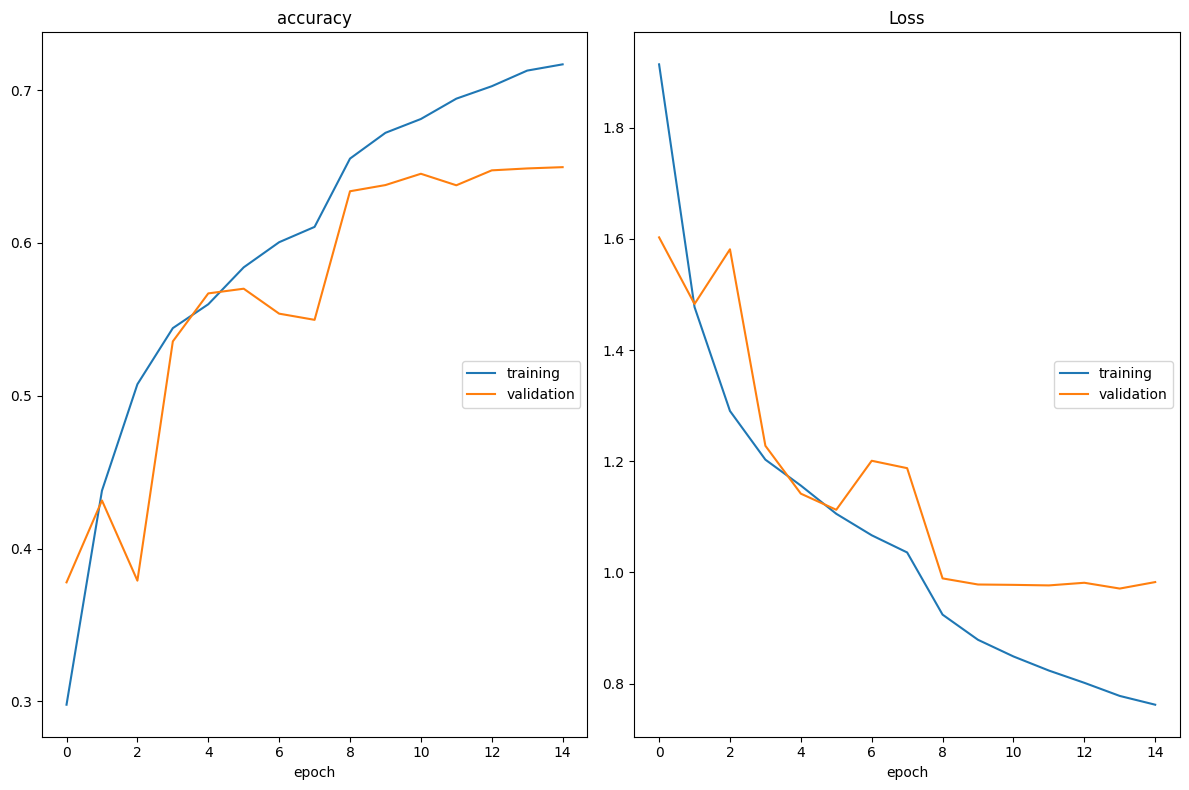

accuracy
	training         	 (min:    0.298, max:    0.717, cur:    0.717)
	validation       	 (min:    0.378, max:    0.650, cur:    0.650)
Loss
	training         	 (min:    0.762, max:    1.914, cur:    0.762)
	validation       	 (min:    0.971, max:    1.603, cur:    0.983)

Epoch 15: saving model to model_weights.h5
448/448 [==============================] - 290s 648ms/step - loss: 0.7622 - accuracy: 0.7168 - val_loss: 0.9827 - val_accuracy: 0.6496 - lr: 1.0000e-04
CPU times: total: 2h 42min 16s
Wall time: 1h 16min


In [5]:
%%time

epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesCallback(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

**Saving the Trained Model**

In [6]:
model.save('Models/model.h5')

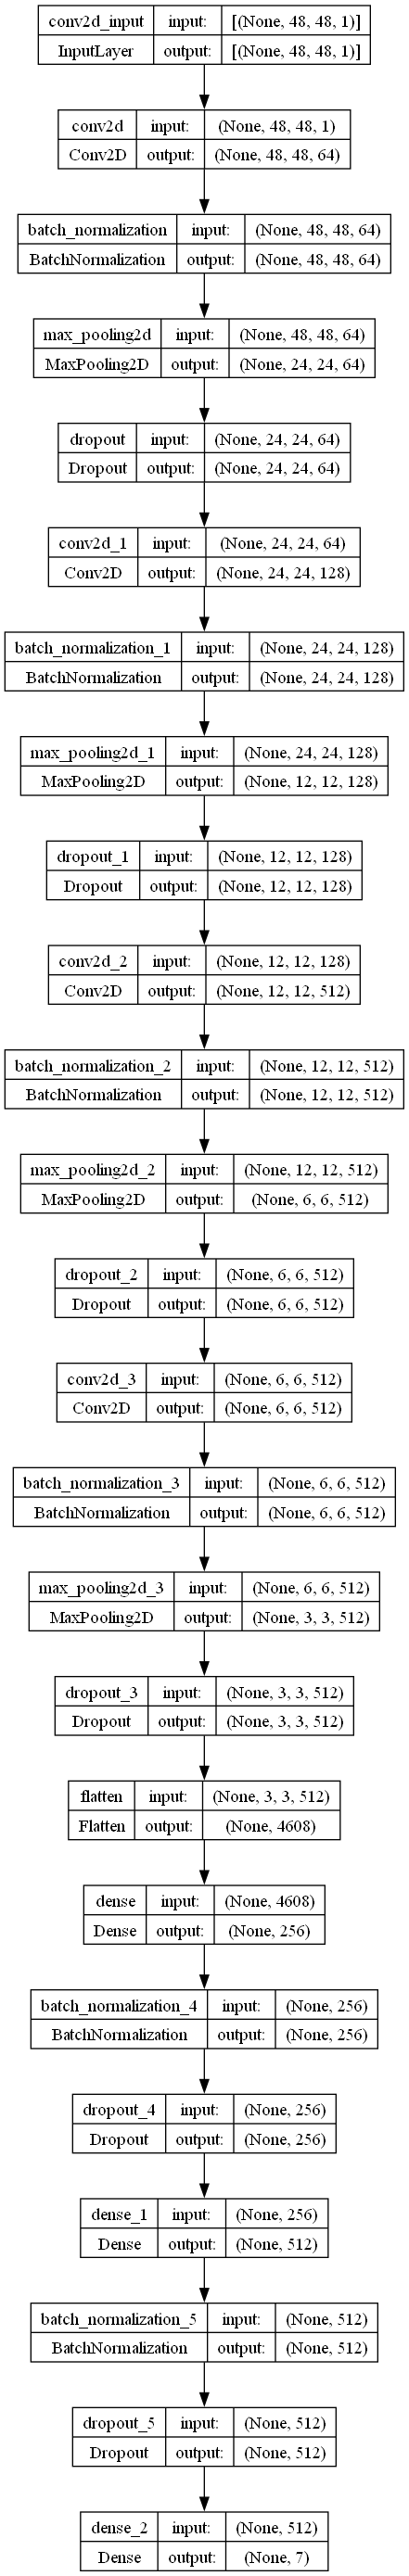

In [5]:
from keras.utils import plot_model
import tensorflow as tf
mod = tf.keras.saving.load_model("Models/model.h5")
plot_model(mod, to_file='Images/model_architecture.png', show_shapes=True, show_layer_names=True)

**Defining Classes and Emotion Lists**

In [1]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model

# Define the FacialExpressionModel class
class FacialExpressionModel:
    EMOTIONS_LIST = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

    def __init__(self, model):
        self.model = model

    def predict_emotion(self, img):
        self.preds = self.model.predict(img)
        return FacialExpressionModel.EMOTIONS_LIST[np.argmax(self.preds)]

**Lodaing The Model**

In [2]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
model = load_model('Models/model.h5')
facec = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
emotion_model = FacialExpressionModel(model)

**Setting Frame Size and Predicting**

In [3]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
class VideoCamera(object):
    def __init__(self, path):
        self.video = cv2.VideoCapture(path)

    def __del__(self):
        self.video.release()

    def get_frame(self):
        _, fr = self.video.read()
        if fr is not None:
            gray_fr = cv2.cvtColor(fr, cv2.COLOR_BGR2GRAY)
            faces = facec.detectMultiScale(gray_fr, 1.3, 5)
            for (x, y, w, h) in faces:
                fc = gray_fr[y:y+h, x:x+w]
                roi = cv2.resize(fc, (48, 48))
                roi = roi.reshape(1, 48, 48, 1)  # Reshape the input to match the model's expected shape
                emotion = emotion_model.predict_emotion(roi)
                cv2.putText(fr, emotion, (x, y), font, 1, (255, 255, 0), 2)
                cv2.rectangle(fr, (x, y), (x+w, y+h), (255, 0, 0), 2)
        return fr

# Final OUTPUT

**Predicting By Accessing the Camera**

In [4]:
def gen(camera):
    while True:
        frame = camera.get_frame()
        if frame is not None:
            cv2.imshow('Facial Expression Recognition', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()

# Define the font in the global scope
font = cv2.FONT_HERSHEY_SIMPLEX

# Create a VideoCamera instance and start capturing frames
if __name__ == "__main__":
    path_to_camera = 0  # 0 corresponds to the default camera, change it if necessary
    camera = VideoCamera(path_to_camera)
    gen(camera)

1/1 [==============================] - 0s 31ms/step
